# Initial Imports and Function Definitions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
def plot_corr(data, title=None):
    """Uses seaborn to plot a correlation matrix of the input data"""
    
    corr_unsorted = data.corr().values
    order = np.array(hierarchy.dendrogram(hierarchy.ward(corr_unsorted), no_plot=True)['ivl'], dtype="int")
    corr = corr_unsorted[order, :][:, order]

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,
               xticklabels=data.columns[order],
               yticklabels=data.columns[order])
    plt.title(title)

In [ ]:
def plot_coef(estimator, features, estimator_name=None, title=None, num_features=None):
    """Function to plot the coefficients of a fitted linear estimator"""
    
    # Grab the estimator from a GridSearchCV object if necessary
    if estimator_name:
        pipe = estimator.best_estimator_
        estimator = pipe.named_steps[estimator_name]
        
    features_short = [x[8:] for x in features]
    
    # Transform for poly feature names if applicable
    try:
        features_final = pipe.named_steps['poly'].get_feature_names(features_short)
    
    except KeyError:
        features_final = features_short
    
    coef_df = pd.DataFrame({
        'feature': features_final,
        'coefficient': estimator.coef_,
        'abs': abs(estimator.coef_)
                           }) \
        .sort_values('abs', ascending=False)
    
    if num_features:
        coef_df = coef_df.iloc[:num_features]
    
#     plt.figure(figsize=(20,10))
#     sns.set()
    return sns.barplot(x='coefficient', y='feature', data=coef_df, orient='h')
#     plt.show()
#     plt.title(title)


In [ ]:
def perm_plot(perm, features, title=None):
    """Creates a bar plot of permutation importances from a fitted eli5.sklearn.PermutationImportance object"""
    
    perm_results = np.mean(np.array(perm.results_), axis=0)
    perm_df = pd.DataFrame({
        'feature': [x[8:] for x in features],
        'importance': perm_results
                       }) \
    .sort_values('importance', ascending=False)
    
#     plt.figure(figsize=(20,10))
#     sns.set()
    return sns.catplot(y='feature', x='importance', data=perm_df, kind='bar', orient='h');
#     plt.show()
#     plt.title(title)

# Data Reading and Visualizations

In [ ]:
X = pd.read_csv(r'X_priority.csv').iloc[:, 1:]
y = pd.read_csv(r'y_priority.csv').iloc[:, 1]

# Drop null values
X.dropna(how='all', inplace=True)
y = y.reindex_like(X)

In [7]:
print('Check that X and y have the same values after dropping NA values: {}'.format(len(X) == len(y)))

Check that X and y have the same values after dropping NA values: True


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24075 entries, 0 to 24504
Data columns (total 48 columns):
m10_cen_memi_x       22682 non-null float64
t10_cen_blk_ml       24075 non-null float64
t10_gis_area_k       24075 non-null float64
t10_ldb_a60up_c      24075 non-null float64
t10_ldb_a75up_c      24075 non-null float64
t10_ldb_ag25up_c     24075 non-null float64
t10_ldb_asian_p      24075 non-null float64
t10_ldb_col_p        24075 non-null float64
t10_ldb_fb_p         24075 non-null float64
t10_ldb_hh_c         24074 non-null float64
t10_ldb_hinci_m      24074 non-null float64
t10_ldb_hisp_p       24074 non-null float64
t10_ldb_hs_p         24074 non-null float64
t10_ldb_lep_p        24074 non-null float64
t10_ldb_mhmvali_m    24074 non-null float64
t10_ldb_mrenti_m     24074 non-null float64
t10_ldb_multi_p      24074 non-null float64
t10_ldb_nhblk_p      24074 non-null float64
t10_ldb_nhwht_p      24074 non-null float64
t10_ldb_npov_c       24074 non-null float64
t10_ldb_npo

**m10_cen_memi_x** is the only variable that has missing values.

In [9]:
X.describe()

,m10_cen_memi_x,t10_cen_blk_ml,t10_gis_area_k,t10_ldb_a60up_c,t10_ldb_a75up_c,t10_ldb_ag25up_c,t10_ldb_asian_p,t10_ldb_col_p,t10_ldb_fb_p,t10_ldb_hh_c,t10_ldb_hinci_m,t10_ldb_hisp_p,t10_ldb_hs_p,t10_ldb_lep_p,t10_ldb_mhmvali_m,t10_ldb_mrenti_m,t10_ldb_multi_p,t10_ldb_nhblk_p,t10_ldb_nhwht_p,t10_ldb_npov_c,t10_ldb_npov_p,t10_ldb_own_p,t10_ldb_pop_c,t10_ldb_pop_d,t10_ldb_unemp_p,t10_ldb_vac_p,t10_net_act_c,t10_net_amb_c,t10_net_apa_c,t10_net_aur_c,t10_net_bar_c,t10_net_cer_c,t10_net_dra_c,t10_net_ffa_c,t10_net_fin_c,t10_net_fsa_c,t10_net_fsr_c,t10_net_hoi_c,t10_net_hsr_c,t10_net_kct_c,t10_net_liq_c,t10_net_mul_c,t10_net_ngt_c,t10_net_pht_c,t10_net_res_c,t10_net_srv_c,t10_net_wal_c,t10_use_green_k
count,22682.000000,24075.000000,24075.000000,24075.000000,24075.000000,24075.000000,24075.000000,24075.000000,24075.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000,24074.000000
mean,1.073054,0.049756,87.379618,834.649387,270.882409,2977.803115,0.057630,0.272208,0.159518,1637.861510,57781.339143,0.213739,0.433453,0.067521,247741.154895,858.911931,0.252082,0.125518,0.577193,667.881781,0.158695,0.641908,4501.872020,1919.273025,0.108398,0.117905,15.365257,14.744853,3.252712,7.845975,1.114455,3.699900,0.961311,2.686733,1.401645,7.093586,17.982761,0.620404,0.643524,0.092116,0.719058,1.532948,1.143599,0.646033,1.015519,3.086525,88.300166,78.899456
std,0.260230,0.111722,439.332269,474.816964,199.331650,1308.386647,0.103140,0.183648,0.153156,713.271341,27863.826062,0.241486,0.185278,0.091236,185404.142630,384.561178,0.251357,0.213454,0.304757,545.696617,0.116680,0.218202,2040.925081,3009.697371,0.059441,0.097415,26.728284,25.764340,3.487518,7.108903,1.805203,5.340843,1.346928,3.452210,2.345770,5.778717,13.066503,1.353405,1.053997,0.368401,1.059794,1.900361,1.847100,1.153843,1.455433,4.194319,72.288705,419.551522
min,1.000000,0.001291,0.008299,10.000000,0.000000,349.000000,0.000000,0.000000,0.000000,22.000000,8760.747070,0.000000,0.003487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,544.000000,0.136506,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.015521,1.692082,510.000000,138.000000,2079.500000,0.003200,0.130396,0.039247,1144.000000,38497.051758,0.038458,0.289350,0.007559,116901.578130,562.859436,0.045802,0.007294,0.321461,273.000000,0.070683,0.499130,3116.000000,225.281445,0.067002,0.053531,2.400000,2.400000,1.000000,3.000000,0.000000,1.000000,0.000000,0.200000,0.000000,3.200000,9.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,44.000000,0.005400
50%,1.000000,0.022100,4.075202,745.000000,226.000000,2801.000000,0.019231,0.221420,0.108927,1537.000000,51613.378906,0.113933,0.441568,0.029576,184798.953130,801.976318,0.171488,0.035428,0.649629,516.000000,0.128474,0.689393,4220.000000,1078.274048,0.096710,0.093390,7.000000,6.600000,2.200000,6.000000,0.600000,2.400000,0.400000,1.600000,0.600000,5.800000,15.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.600000,0.000000,0.600000,2.000000,69.800000,0.530103
75%,1.000000,0.034715,22.223116,1053.000000,349.000000,3655.000000,0.062283,0.380041,0.239125,2014.000000,70509.906251,0.303286,0.573647,0.090098,320569.117188,1099.150391,0.384068,0.128447,0.841484,912.000000,0.218728,0.814690,5527.750000,2419.343933,0.137119,0.153401,16.800000,16.200000,4.400000,10.600000,1.600000,4.600000,1.400000,3.800000,

In [10]:
X.shape

(24075, 48)

## Visualizations

### Target

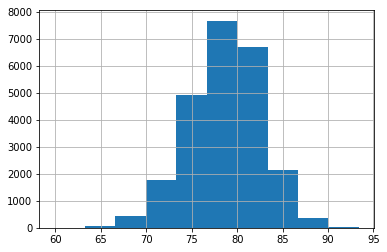

In [11]:
y.hist();

Our target actually looks pretty close to normally distributed which will likely be helpful for linear methods

### Continuous Features 

In [ ]:
bin_features = "m10_cen_memi_x"
cont_features = [x for x in X.columns.tolist() if x !=bin_features]

#### Distributions

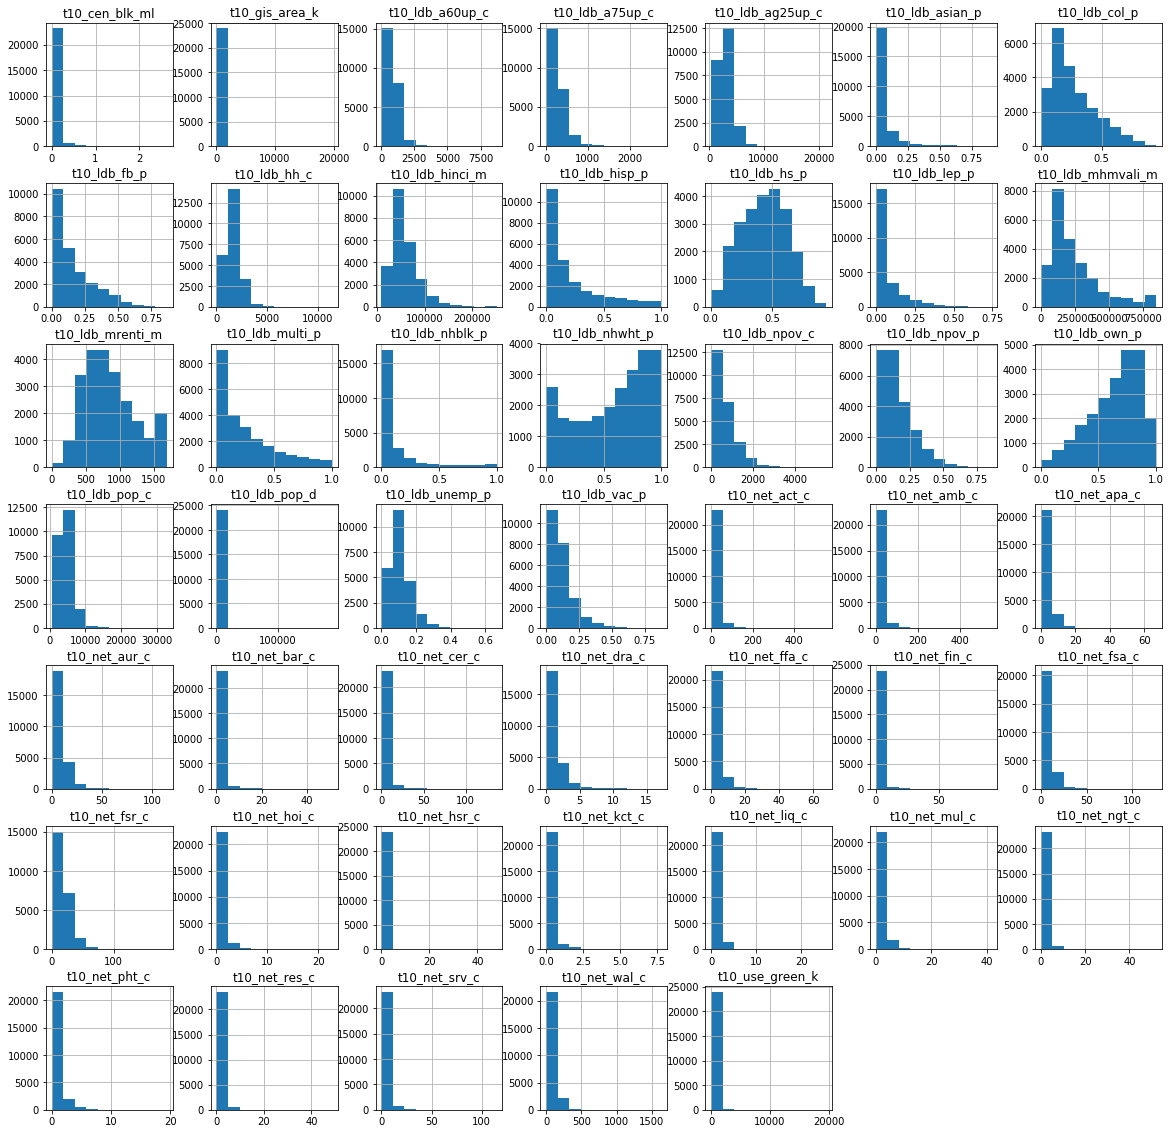

In [13]:
X[cont_features].hist(figsize=(20,20));

A lot of these distributions have very strong left skew, and look vaguely exponential. A few of them look like they may be normal. NETS variables are the most strikingly right skewed, with the vast majority of tracts having a very small number of each kind of business.  

The LTDB variables are not quit as striking, and seem to have a lot more tract-level variety. 

### Categorical Feature(s) \[Needs filling in\]

The only binary feature is m10_cen_memi_x.

### Feature-wise Plots vs Target

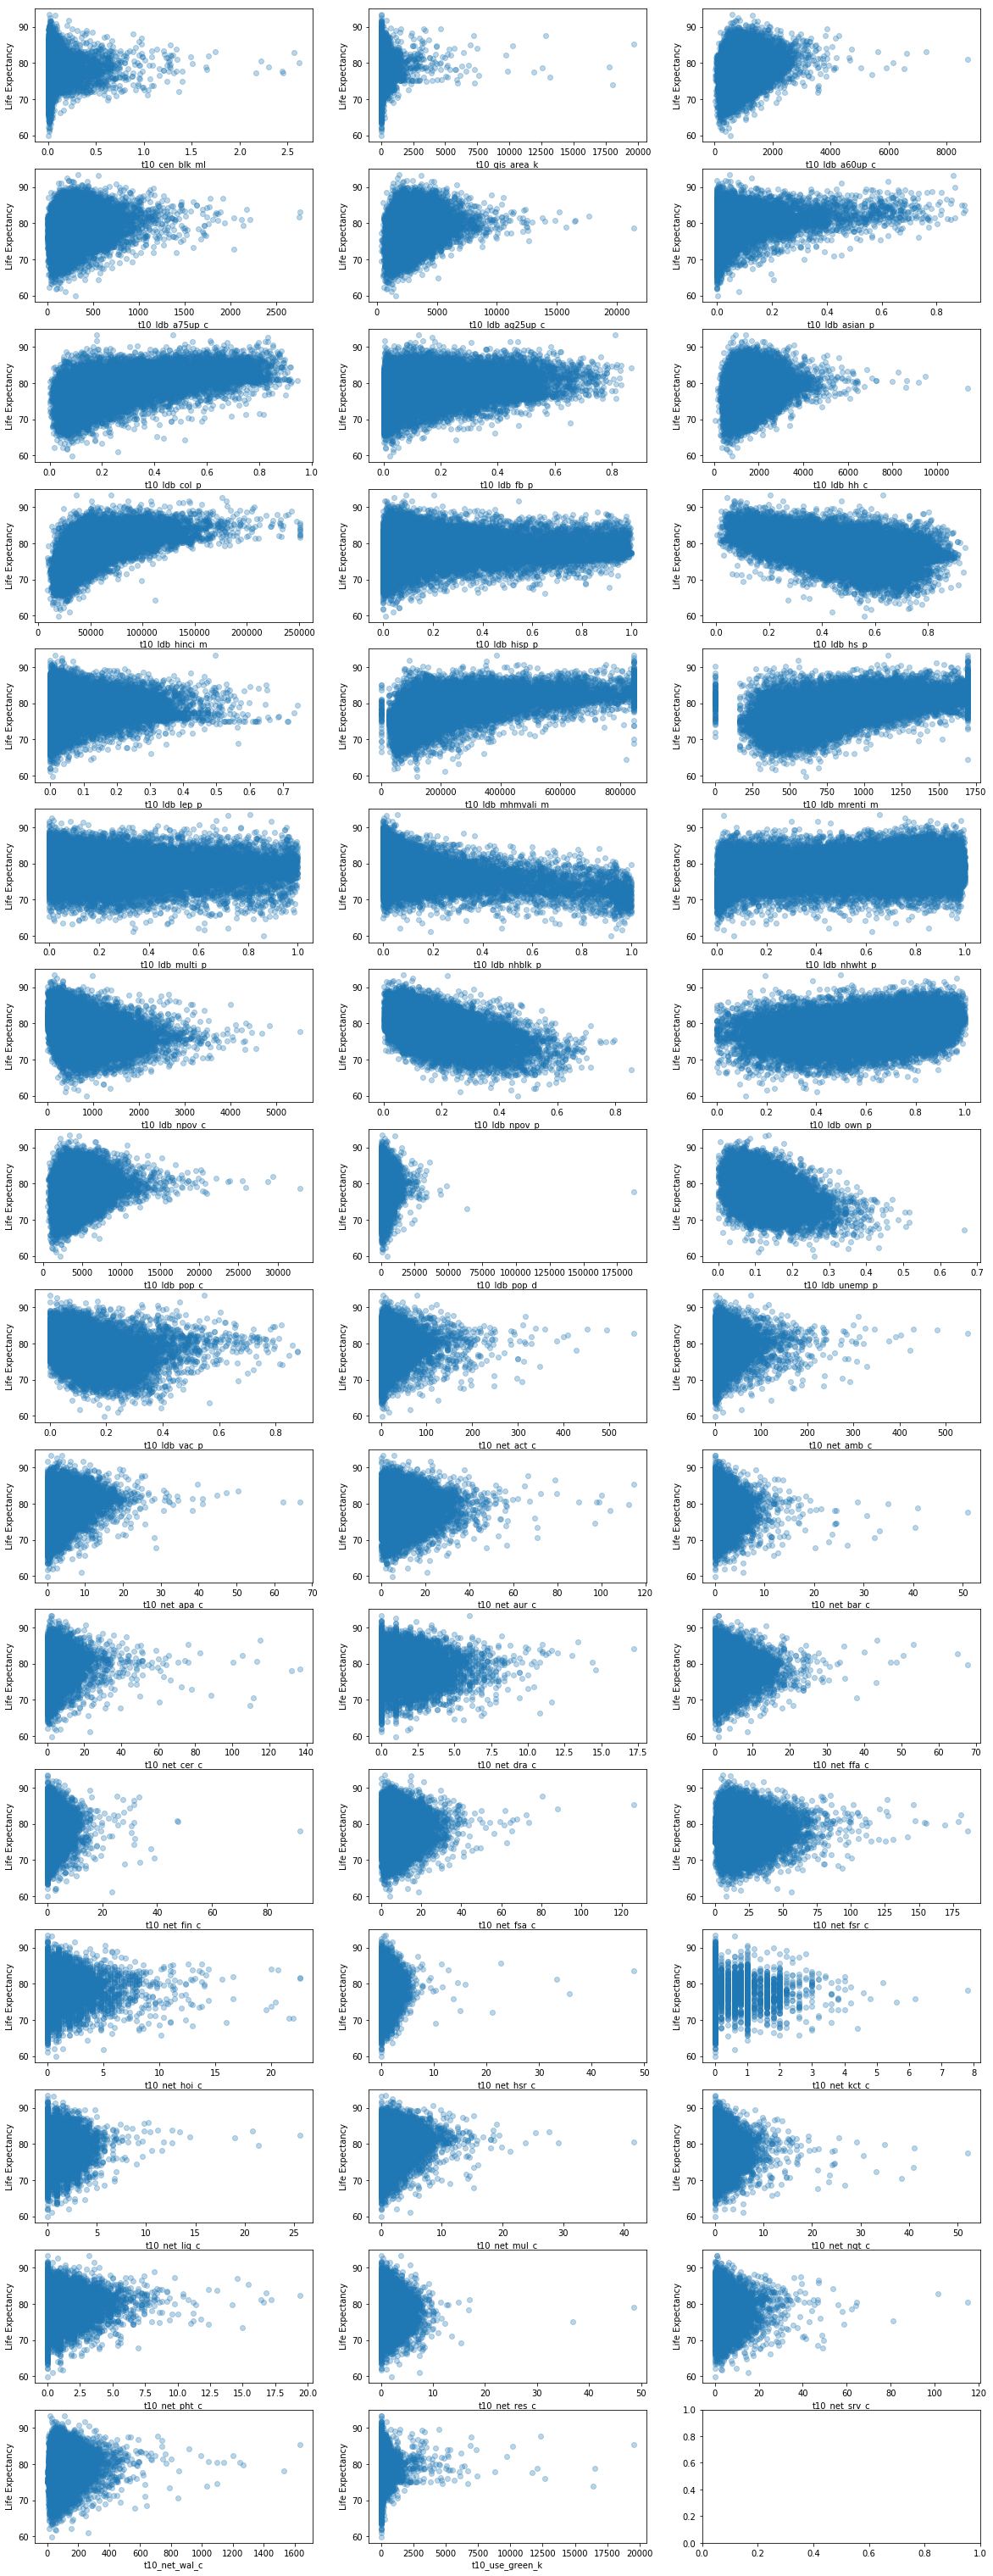

In [14]:
nrows=16
ncols=3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,55));
k = 0
for i in range(nrows):
    for j in range(ncols):
        try:
            feature = X[cont_features].iloc[:, k]
            axes[i, j].set(xlabel=feature.name,
                          ylabel="Life Expectancy");
            axes[i, j].scatter(x=feature, y=y, alpha=0.3);
            k += 1
        except IndexError:
            break

Many of these plots, **especially** the NETS ones, show heteroskedacicity.  We're not very concerened with p-values and confidence intervals so it may not be a problem but it is definitely something to note.

### Collinearities

We're expecting a lot of collinearity, especially within LTDB and census varuables. I attempted a pairplot, but there were too many variables for this to be useful.

# Analysis

In [16]:
! pip install eli5

     |████████████████████████████████| 102kB 2.0MB/s 


In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from eli5 import explain_weights, show_weights
from eli5.sklearn import PermutationImportance

from scipy.cluster import hierarchy

## Split Data

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[cont_features], y, random_state=0)

# Define a repeatable Cross-Validation Generator
cv_5 = KFold(n_splits=5, shuffle=True, random_state=42)

## Single Variables

In [ ]:
results = {}
for col in cont_features:
    lr = LinearRegression()
    score = cross_val_score(lr, X_train[col].values.reshape(-1,1), y_train, cv=cv_5, scoring='r2')
    results[col] = np.mean(score)

results_df = pd.Series(results).sort_values(ascending=False)

In [20]:
results_df

t10_ldb_hinci_m      0.368779
t10_ldb_col_p        0.328455
t10_ldb_mhmvali_m    0.324170
t10_ldb_npov_p       0.319686
t10_ldb_hs_p         0.300398
t10_ldb_mrenti_m     0.291912
t10_ldb_nhblk_p      0.224539
t10_ldb_unemp_p      0.194901
t10_ldb_npov_c       0.126901
t10_ldb_asian_p      0.104828
t10_ldb_vac_p        0.075957
t10_ldb_own_p        0.073927
t10_ldb_fb_p         0.072665
t10_net_apa_c        0.058257
t10_ldb_ag25up_c     0.057751
t10_ldb_a60up_c      0.049150
t10_net_mul_c        0.040828
t10_ldb_hh_c         0.032579
t10_ldb_pop_c        0.030474
t10_ldb_a75up_c      0.030221
t10_ldb_nhwht_p      0.029886
t10_net_pht_c        0.017455
t10_net_amb_c        0.016896
t10_net_act_c        0.015551
t10_net_cer_c        0.011571
t10_net_wal_c        0.005972
t10_ldb_pop_d        0.004078
t10_ldb_multi_p      0.003952
t10_ldb_lep_p        0.003675
t10_ldb_hisp_p       0.003153
t10_net_kct_c        0.003052
t10_net_bar_c        0.001934
t10_net_fsr_c        0.001863
t10_net_ng

We have some pretty good univariate predictors.  As expected, all of the top performers are LTDB variables.  The following LTDB variables all produce an R<sup>2</sup> of > 0.3:
* **hinci_m**: Median household income
* **col_p**: Percent of persons with at least a 4-year college degree
* **npov_p**: Percent of persons in poverty
* **hs_p**: Percent of persons with a high school degree or less
* **mhmvali_m**: Medidan home value (inflation-adjusted)

I suspect that many of these variables will be highly correlated, so I'll look at a covariance matrix.

In [ ]:
high_r_cols = results_df[results_df > .3].index

In [22]:
X_train[high_r_cols].corr()

,t10_ldb_hinci_m,t10_ldb_col_p,t10_ldb_mhmvali_m,t10_ldb_npov_p,t10_ldb_hs_p
t10_ldb_hinci_m,1.000000,0.749431,0.704735,-0.687899,-0.716910
t10_ldb_col_p,0.749431,1.000000,0.685998,-0.537721,-0.908137
t10_ldb_mhmvali_m,0.704735,0.685998,1.000000,-0.388175,-0.596177
t10_ldb_npov_p,-0.687899,-0.537721,-0.388175,1.000000,0.624815
t10_ldb_hs_p,-0.716910,-0.908137,-0.596177,0.624815,1.000000


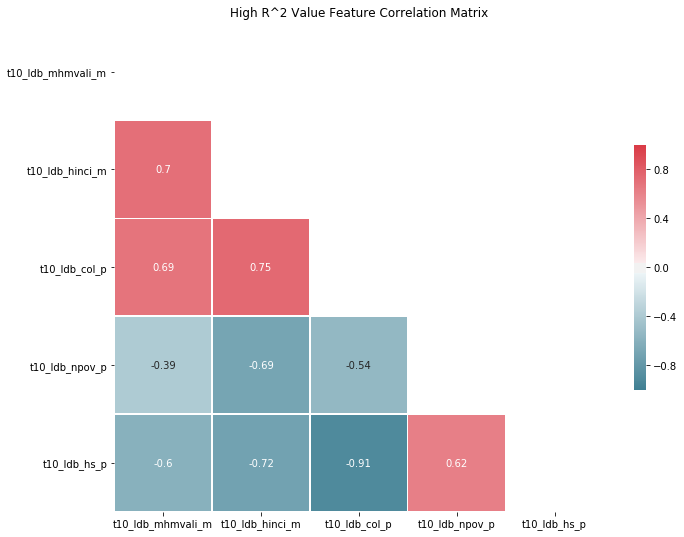

In [23]:
plot_corr(X_train[high_r_cols], title='High R^2 Value Feature Correlation Matrix')

We do see some pretty high correlations, but not as high as I was expecting in most cases. The highest is a negative correlation between the  number of percent of people with at least a college degree and the percent of people with at most a high school degree, which are obviously in direct opposition.  There's also a pretty strong positive correlation between college degrees and median household income, which once again isn't surprising and I imagine most of these things are pretty well studied already.  

# Phase 1

Features will only include the intersection of Census and ACS variables used in USALEEPs model to impute life expectancy for age-bands with death counts of 0 and those which are found in the RECVD priority dataset. These include median household income, population density, and the proportions of the population that are non-Hispanic black, Hispanic, and had a 4-year college degree or higher in the census tract.

**Full variable names**:
- t10_ldb_hinc_m
- t10_ldb_pop_d
- t10_ldb_nhblk_p
- t10_ldb_hisp_p
- t10_ldb_col_p


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Linear Models

We'll create a phase 1 model using Ridge regression, LASSO regression, and ElasticNet. The baseline model will include all variables except NETS variables. We'll try both StandardScaler and RobustScaler (which uses the median and quartiles to reduce the influence of outliers on scaling). Due to the high correlation between variables, we won't use standard Ordinary Least Squares Regression as we won't be able to trust the coefficients, which is our initial method of identifying variable importance.

In [ ]:
def linear_model(estimator, param_grid, cv, X_train, y_train, phase):
    """Functional code to perform all operations for a Linear Model and return a fitted GridSearchCV
    
    Keyword Arguments:
    estimator -- The scikit-learn estimator to use
    param_grid -- Dict object detailing parameters for the model
    cv -- the cross-validation generator object
    X_train -- training data features
    y_train -- training data outcome
    phase -- Which phase of analysis this is for labeling charts, as a string (Ex: 1)
    """
    
    est_str = str(estimator)
    est_name = est_str[:est_str.index('(')]
    
    pipe = Pipeline([
        ('poly', PolynomialFeatures()),
        ('scaler', StandardScaler()),
        ('estimator', estimator)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    train_results = pd.DataFrame(grid.cv_results_)
    
    #get the best linear estimator for comparison
    lin_best = train_results[train_results['param_poly__degree'] == 1] \
    .sort_values('rank_test_score') \
    .iloc[0] \
    .mean_test_score
    
    # Print results
    print(
    "Phase 1 {} R^2 Value: {}\n\
Best Parameters: {}\n\n\
Best R^2 Value with No Polynomial Features or Interactions: {}\n" \
    .format(est_name, grid.best_score_, grid.best_params_, lin_best)
)
    
#     Coefficient graphs
    plt.figure(figsize=(20,10));
    sns.set()
    coef_plot = plot_coef(grid,
              X_train.columns,
              estimator_name='estimator',
              num_features=20)
    plt.title('Phase 1 {} Coefficients'.format(est_name))
    plt.show()
   
    
    #permutation importance
    perm = PermutationImportance(grid.best_estimator_, scoring='r2') \
        .fit(X_train, y_train, cv='prefit')
    
    plt.figure(figsize=(20,10));
    plot_perm = perm_plot(perm, X_train.columns.tolist())
    plt.title('Phase {} {} Permutation Importance'.format(phase, est_name))
    plt.show()
    
    display(show_weights(perm, feature_names=X_train.columns.tolist()))    
    
    return grid

In [ ]:
p1_features = ['t10_ldb_hinci_m',
    't10_ldb_pop_d',
    't10_ldb_nhblk_p',
    't10_ldb_hisp_p',
    't10_ldb_col_p']

Correlation matrix for Phase 1 Features

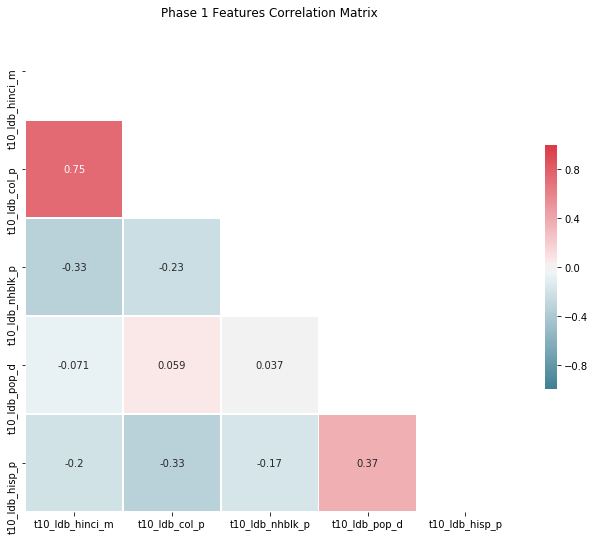

In [27]:
plot_corr(X_train[p1_features], title='Phase 1 Features Correlation Matrix')

There's a 0.75 correlation between median household income and percent with a four year degree, which is pretty obvious and to be expected.  Other than this the correlations between variables aren't as drastic as I had imagined

### LASSO Regression

Lasso regression performs L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This type of regularization can result in sparse models with few coefficients; Some coefficients can become zero and eliminated from the model. Larger penalties result in coefficient values closer to zero, which is the ideal for producing simpler models.

![alt text](https://qph.fs.quoracdn.net/main-qimg-2a88e2acc009fa4de3edeb51e683ca02.webp)

As shown in the image, the nature of the l1 norm function and its use of the absolute value drives coefficients directly to 0, while l2 norm used for ridge regression just drives them *close* to 0.  

I'll be gridsearching for the optimum $\alpha$ parameter on a log scale.

Phase 1 Lasso R^2 Value: 0.5515238735826332
Best Parameters: {'estimator__alpha': 0.03162277660168379, 'poly__degree': 3}

Best R^2 Value with No Polynomial Features or Interactions: 0.5173892504804124



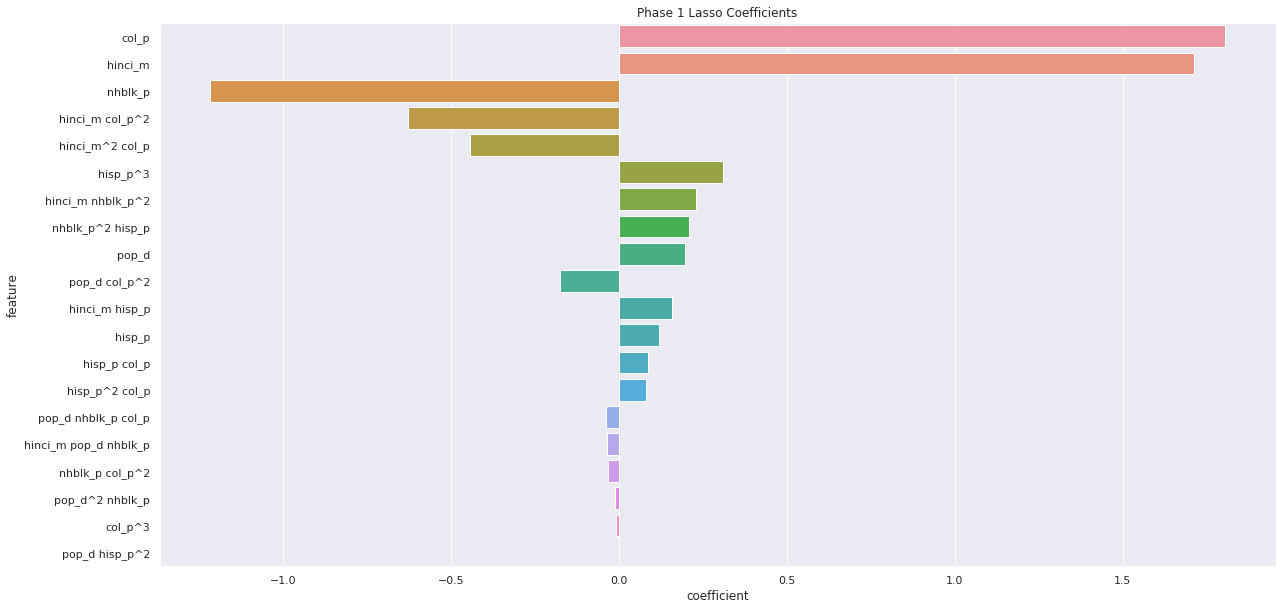

<Figure size 1440x720 with 0 Axes>

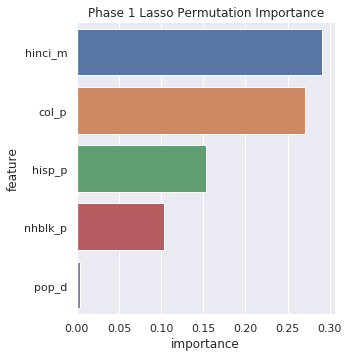

Weight,Feature
0.2912 ± 0.0110,t10_ldb_hinci_m
0.2704 ± 0.0036,t10_ldb_col_p
0.1538 ± 0.0070,t10_ldb_hisp_p
0.1035 ± 0.0070,t10_ldb_nhblk_p
0.0042 ± 0.0008,t10_ldb_pop_d


In [28]:
lasso_grid = {
    'estimator__alpha': np.logspace(-3, 3, 5),
    'poly__degree': [1, 2, 3]
             }
p1_lasso = linear_model(Lasso(), lasso_grid, cv_5, X_train[p1_features], y_train, '1');

Our best model used the smallest regularization parameter.  we also see a .065 increase in R^2 when we use a model with 3rd order polynomials and interaction terms.

The previous conclusion is emphasized by viewing the coefficients; LASSO has set none of them to zero.

Permutation importances largely agree with the LASSO Coefficients as effect estimates, assigning high importances to median household income, percentage of those with a 4-year degree or higher, and proportion of non-hispanic black residents. This also has an interpretability advantage that it assigns importance based on the original features despite us using polynomial features and interactions.  This is because in computing the permutation importance, each feature is randomly permuted before polynomial features and itneractions are taken.

#### Permutation Importance

from [eli5](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)  

**Algorithm:**  
The idea is the following: feature importance can be measured by looking at how much the score (accuracy, F1, R^2, etc. - any score we’re interested in) decreases when a feature is not available.

To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. Also, it shows what may be important within a dataset, not what is important within a concrete trained model.

To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It doesn’t work as-is, because estimators expect feature to be present. So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.

### Ridge

Ridge regression performs L2 regularization, which adds a penalty equal to the square of the magnitude of coefficients. This type of regularization will push values very close to 0, but will none will actually reach 0. Larger penalties result in coefficient values closer to zero, which is the ideal for producing simpler models.

Refer to the image shown in the LASSO section: the nature of the l1 norm function and its use of the absolute value drives coefficients directly to 0, while l2 norm used for ridge regression just drives them *close* to 0.  

I'll be using the gridsearching for the optimum $\alpha$ parameter on a log scale.

Phase 1 Ridge R^2 Value: 0.5476303822331178
Best Parameters: {'estimator__alpha': 31.622776601683793, 'poly__degree': 2}

Best R^2 Value with No Polynomial Features or Interactions: 0.5173888123771141



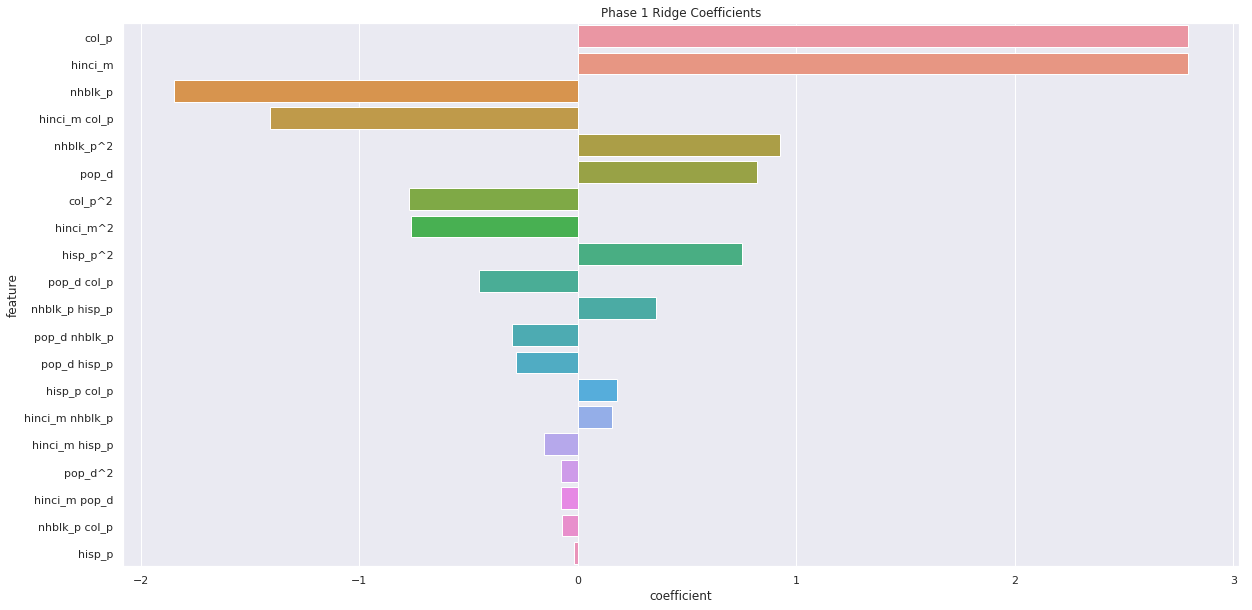

<Figure size 1440x720 with 0 Axes>

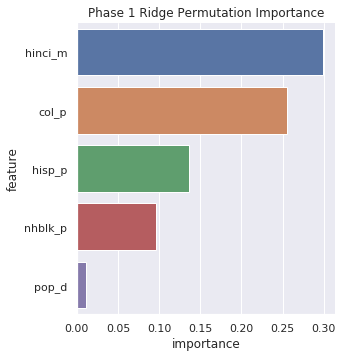

Weight,Feature
0.2990 ± 0.0089,t10_ldb_hinci_m
0.2559 ± 0.0064,t10_ldb_col_p
0.1358 ± 0.0072,t10_ldb_hisp_p
0.0962 ± 0.0153,t10_ldb_nhblk_p
0.0111 ± 0.0034,t10_ldb_pop_d


In [29]:
ridge_grid = {
    'estimator__alpha': np.logspace(-3, 3, 5),
    'poly__degree': [1, 2, 3]
             }
p1_ridge = linear_model(Ridge(), ridge_grid, cv_5, X_train[p1_features], y_train, '1');

As expected, results are nearly identical to LASSO. The ridge model performs the same both linearly and with polynomial features. One notable difference in that percent of persons with college degrees surpasses median household income as the most important feature by permutation importance, but they were very close to begin with. There are some small differences in coefficient weights and what is represented for polynomial features but in general things are very similar.

### ElasticNet

![](https://miro.medium.com/max/4200/0*kuuC8_3Q2YjoLoqt.png)

ElasticNet uses the sum of the L1 and L2 norms and acts as a compromise between Ridge and LASSO. Coefficients will sometimes be set to 0, but less commonly than with LASSO.

Phase 1 ElasticNet R^2 Value: 0.5545655127706381
Best Parameters: {'estimator__alpha': 0.03162277660168379, 'estimator__l1_ratio': 0.25, 'poly__degree': 3}

Best R^2 Value with No Polynomial Features or Interactions: 0.5173892504804124



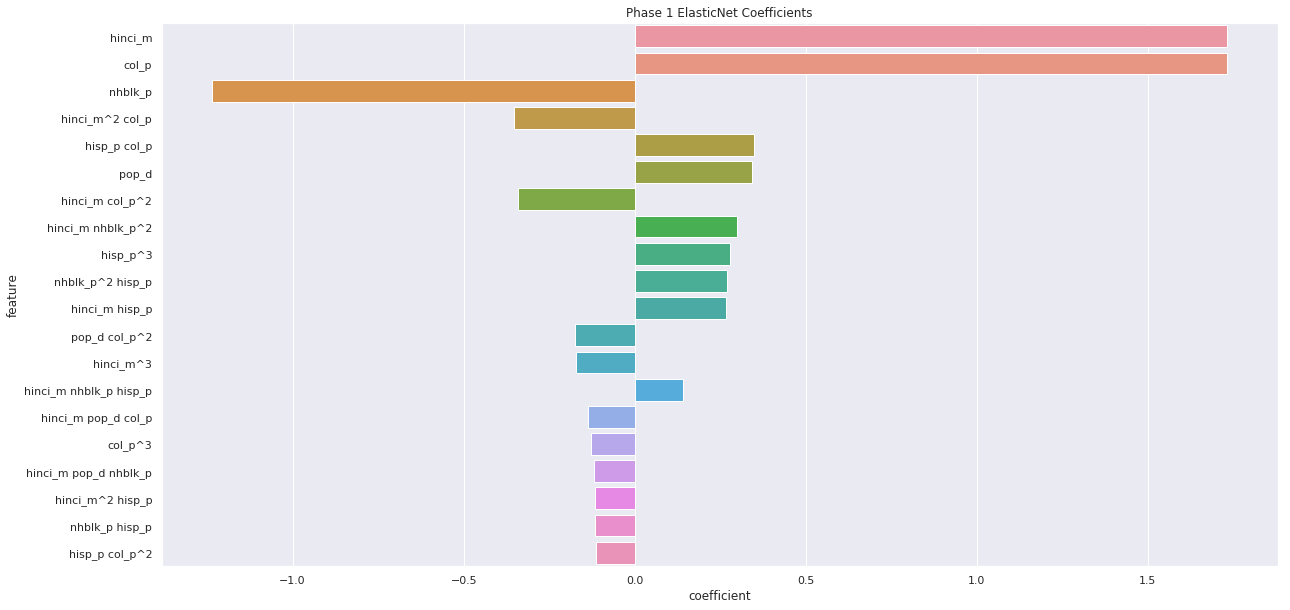

<Figure size 1440x720 with 0 Axes>

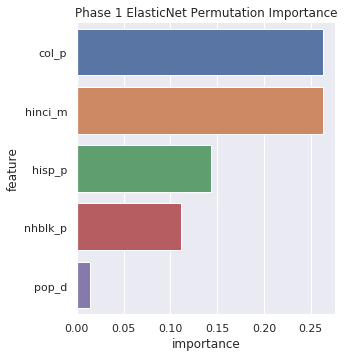

Weight,Feature
0.2630 ± 0.0060,t10_ldb_col_p
0.2627 ± 0.0048,t10_ldb_hinci_m
0.1433 ± 0.0073,t10_ldb_hisp_p
0.1118 ± 0.0061,t10_ldb_nhblk_p
0.0145 ± 0.0191,t10_ldb_pop_d


In [30]:
elastic_grid = {
    'estimator__alpha': np.logspace(-3, 3, 5),
    'estimator__l1_ratio': np.linspace(0, 1, 5),
    'poly__degree': [1, 2, 3]
             }
p1_elastic = linear_model(ElasticNet(), elastic_grid, cv_5, X_train[p1_features], y_train, '1');

Basically the same as the other linear methods

## Nonlinear Models
### Random Forests

![](https://miro.medium.com/max/1184/1*i0o8mjFfCn-uD79-F1Cqkw.png)

A random forrest is an ensemble classifier/regressor of bad decision trees which average to (hopefully) be a good classfier/regressor. The idea is that although each of these small decision trees perform badly, they all capture *different* information and so average to be a good model of the data. The number of trees in the forest is a hyperparameter, as well as the max depth of the trees. Randomness is injected into these trees in two ways:

1. Bagging (Bootstrap Aggregation).  Each tree is trained on a different bootstrapped sample from our training data.
2. Restricting number of features each tree can be trained on.  Each tree is only allowed to train on a randomly selected set of features.  The number of features is a hyperparameter.

The final classification is made by averaging the individual classifications of each tree in the forest. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
InteractiveShell.ast_node_interactivity = 'last_expr'

## Find the Correct Number of Trees

More trees in your forest can never *hurt* performance, but eventually you reach a point of diminishing returns where you spend extra time training for very little boost in performance.  We'll evaluate performance while adding trees to see how many we need for this problem.

In [ ]:
%%capture

train_scores = []
oob_scores = []
test_scores = []

rf = RandomForestRegressor(warm_start=True, oob_score=True, random_state=42);
estimator_range = range(1, 500, 20)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators;
    rf.fit(X_train[p1_features], y_train);
    train_scores.append(rf.score(X_train[p1_features], y_train));
    oob_scores.append(rf.oob_score_);

In [ ]:
plt.plot(estimator_range, oob_scores, label="Out of Bag scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("R^2")
plt.xlabel("n_estimators")
plt.ylim(0, 1)
plt.legend()
plt.show()
# plt.savefig("images/warm_start_forest.png")

In [ ]:
pd.DataFrame({'num_trees': estimator_range,
              'oob_scores': oob_scores})

If we're looking at R<sup>2</sup> to the precision of the hundredth, we can pick 150 as a nice even number of estimators.
### Parameter Tuning
Let's see if we can improve performance by tuning on the number of features and max depth of the tree.

In [ ]:
from sklearn.model_selection import ParameterGrid

rf = RandomForestRegressor(n_estimators=150, oob_score=True, random_state=42)
grid = {
    'max_features': ['auto', 'sqrt'],
    'max_depth': [1, 5, 10, 20, None]
}

best_score=0
for g in ParameterGrid(grid):
    rf.set_params(**g)
    rf.fit(X_train[p1_features], y_train)
    # save if best
    if rf.oob_score_ > best_score:
        best_score = rf.oob_score_
        best_grid = g

In [33]:
print('Best R^2 Value: {}\n\
Best Parameter Grid: {}'.format(best_score, best_grid))

Best R^2 Value: 0.5914879420994692
Best Parameter Grid: {'max_depth': 10, 'max_features': 'sqrt'}


We'll Use these parameters moving forward with all datasets.

### Feature Importances

In [34]:
rf_p1 = RandomForestRegressor(n_estimators=150, max_depth=10, max_features='auto', oob_score=True, random_state=42)
rf_p1.fit(X_train[p1_features], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

### Gini Importance

From [A scikit-learn core dev](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)

>In scikit-learn, we implement the importance as described in [1] (often cited, but unfortunately rarely read...). It is sometimes called "gini importance" or "mean decrease impurity" and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.

Basically what this comes down to is that if splitting on a feature makes the two leaves below it much more pure (They contain a more concentrated distribution of values), it will be more important than a feature that doesn't increase purity as much, averaged across all trees.

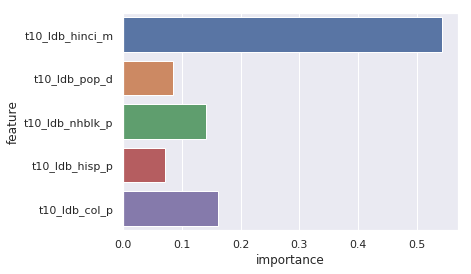

In [35]:
rf_p1_imp = pd.DataFrame({
    'feature': p1_features,
    'importance': rf_p1.feature_importances_ 
})

sns.barplot(x='importance', y='feature', data=rf_p1_imp, orient='h')

This looks different from our results with linear methods in that it gives much more emphasis on the strongest feature, median household income.

### Permutation Importance

<Figure size 1440x720 with 0 Axes>

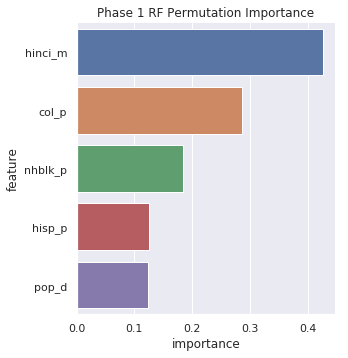

Weight,Feature
0.4268 ± 0.0066,t10_ldb_hinci_m
0.2872 ± 0.0062,t10_ldb_col_p
0.1843 ± 0.0030,t10_ldb_nhblk_p
0.1251 ± 0.0059,t10_ldb_hisp_p
0.1238 ± 0.0044,t10_ldb_pop_d


In [36]:
perm = PermutationImportance(rf_p1, scoring='r2') \
        .fit(X_train[p1_features], y_train, cv='prefit')
    
plt.figure(figsize=(20,10));
plot_perm = perm_plot(perm, p1_features)
plt.title('Phase 1 RF Permutation Importance')    
plt.show()

display(show_weights(perm, feature_names=p1_features))    

This permutation importance shows a much more similar result to the results of the linear methods when compared to gini importance. This is a a good reason to be concerned with the accuracy of gini importance; it can exaggerate the importances of features.

### Partial Dependence Plots

In [ ]:
from sklearn.inspection import plot_partial_dependence

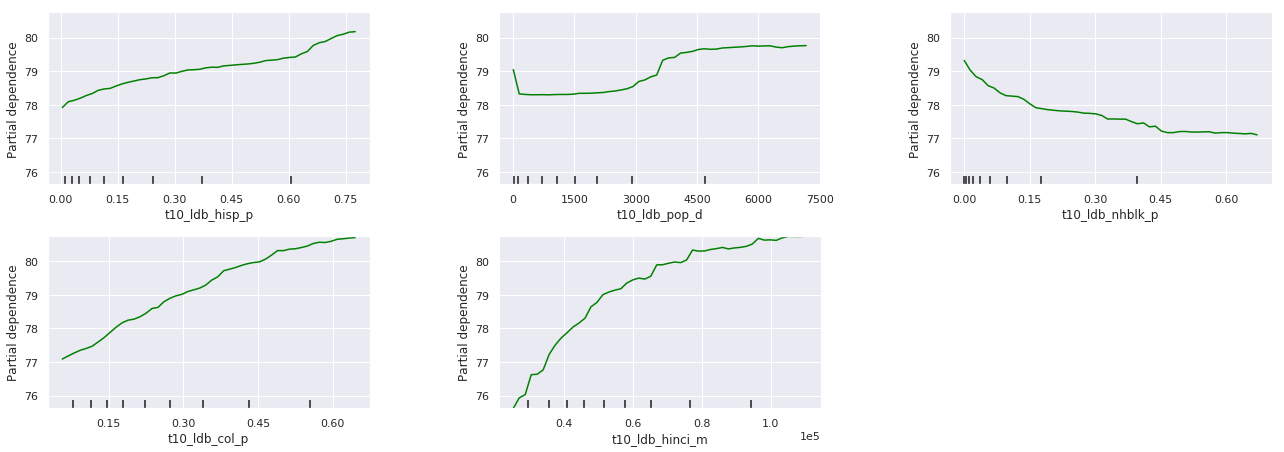

In [38]:
plot_partial_dependence(rf_p1, X_train[p1_features], np.argsort(rf_p1.feature_importances_),
    feature_names=p1_features, n_jobs=-1, grid_resolution=50, fig=plt.figure(figsize=(20,10))) 

We are seeing at least some partial dependence based on all features, with the strongest relationships for percent of college graduates and median household income, which is to be expected. One interesting thing to note is that median household income appears almost asymptotic as we get to very high median incomes, which means that the effect only matters up to a certain point.  The effect of college seems more linear.

### Gradient Boosting with XGBoost

XGBoost is one of the most popular implementation of Gradient Boosted Trees.  This is a method similar to random forests, but rather than using many independent trees it builds trees sequentially, each dependent on the last. It is often done with very shallow trees, or even stumps (trees of depth 1).

![](https://www.researchgate.net/profile/Maria_Peraita-Adrados/publication/326379229/figure/fig5/AS:647978477948928@1531501516288/A-simple-example-of-visualizing-gradient-boosting.png)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate

In [ ]:
xgb_p1 = XGBRegressor(n_jobs=-1)
cval_xgb_p1 = cross_validate(xgb_p1, X_train[p1_features],
    y_train, scoring = 'r2', cv=cv_5, n_jobs=-1)

In [41]:
print("Mean XGBoost Score: {}".format(cval_xgb_p1['test_score'].mean()))

Mean XGBoost Score: 0.5889204324195847


We're already getting a score that rivals the tuned Random Forest score with no parameter tuning using XGBoost.  For now we won't tune parameters (as we're more interested in feature importance) but we'll revisit tuning later.

In [42]:
xgb_p1.fit(X_train[p1_features].values, y_train.values)

[19:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

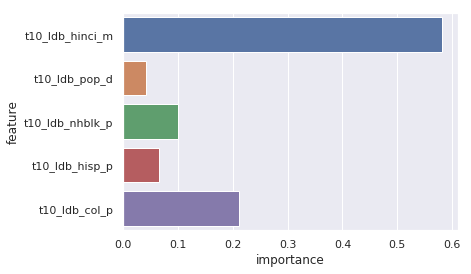

In [43]:
xgb_p1_imp = pd.DataFrame({
    'feature': p1_features,
    'importance': xgb_p1.feature_importances_ 
})

sns.barplot(x='importance', y='feature', data=xgb_p1_imp, orient='h')

<Figure size 1440x720 with 0 Axes>

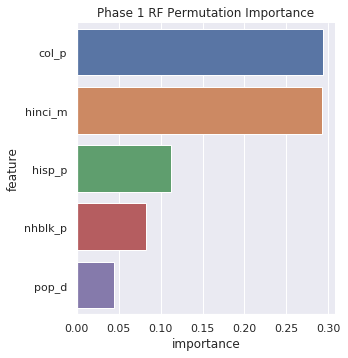

Weight,Feature
0.2936 ± 0.0068,t10_ldb_col_p
0.2919 ± 0.0058,t10_ldb_hinci_m
0.1125 ± 0.0038,t10_ldb_hisp_p
0.0827 ± 0.0028,t10_ldb_nhblk_p
0.0448 ± 0.0007,t10_ldb_pop_d


In [44]:
perm = PermutationImportance(xgb_p1, scoring='r2') \
        .fit(X_train[p1_features].values, y_train.values, cv='prefit')
    
plt.figure(figsize=(20,10));
plot_perm = perm_plot(perm, p1_features)
plt.title('Phase 1 RF Permutation Importance')    
plt.show()

display(show_weights(perm, feature_names=p1_features)) 

Feature importance by Gini importance is the same for XGBoost and Random Forests, but the XGBoost model puts more emphasis on percent college graduates, and less on percentage of the population that is black.  In fact, this is the first model to put higher influence on percentage hispanic than black.

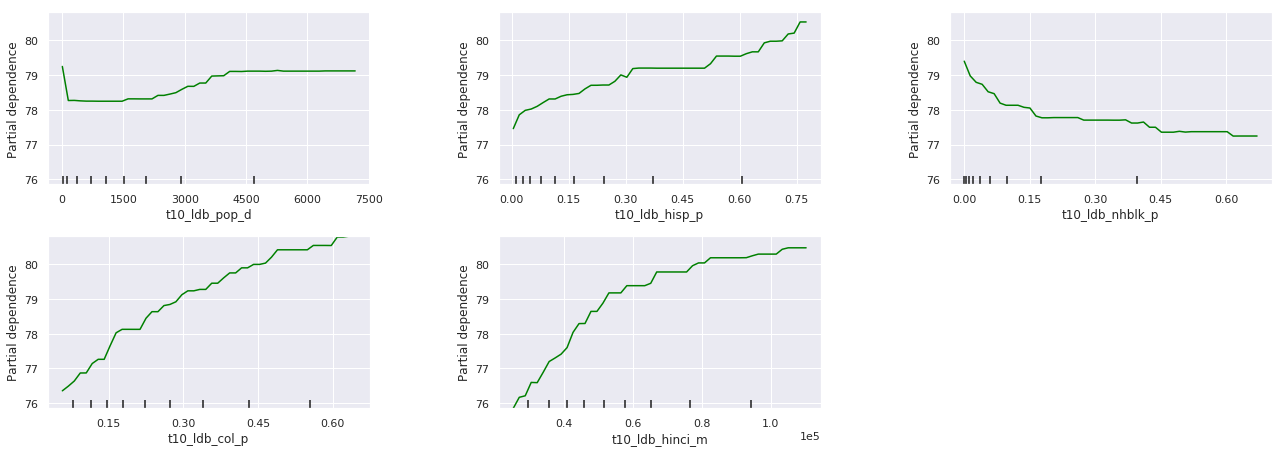

In [45]:
plot_partial_dependence(xgb_p1, X_train[p1_features].values, np.argsort(xgb_p1.feature_importances_),
    feature_names=p1_features, n_jobs=-1, grid_resolution=50, fig=plt.figure(figsize=(20,10))) 

These plots look largely the same as the ones for the random forests. It looks like some tracts may have a population density of zero? We'll check that out.

In [46]:
(X_train['t10_ldb_pop_d'] == 0).value_counts()

False    18056
Name: t10_ldb_pop_d, dtype: int64

No, actually they must just be very small population density values.  In this case it looks like tracts with extremely low population density values have similar life expectancy to those with the highest population density.  However, these values abruptly drop off when they get a little higher, and then slowly climb back up. 

### Phase 1 Conclusions

**Linear models**:  
Perhaps because of the small number of features, we get similar performance from all types of linear models (LASSO, Ridge, ElasticNet). Fully linear models reach an R<sup>2</sup> value of about 0.49, while adding interaction terms and polynomial features up to the order of 3 boost us to an R<sup>2</sup> of around 0.55.  These models all agree that the two most important features are median household income and percent of residents with at least a 4 year degree, with the former slightly outweighing the latter. Both have positive relationships, while the third most important feature (by all measures) is percent non-hispanic black, which has a negative relationship (although it is much less strong than the previous two.

**NonLinear Models**
Random Forests achieved an R<sup>2</sup> of 0.58 with parameter tuning which XGBoost also achieved with no parameter tuning.  Both models had nearly identical Gini importances of features, which largely agreed with the linear models.  However, when using permutation importance college and income became much closer in importance, and in the gradient boosting model percentage hispanic overtook percentage non-hispanic black for third most important feature.  We can see from the partial dependence plots (as well as plotting this directly against life expectancy, as we did at the beginning), that percent hispanic has a positive relationship.

# Phase 2

Features will all Census and ACS variables in the RECVD priority dataset. 

**Full variable names**:
- t10_ldb_hinc_m - Median household income
- t10_ldb_pop_d - Population density
- t10_ldb_nhblk_p - Percent non-hispanic black
- t10_ldb_hisp_p - Percent hispanic
- t10_ldb_col_p - Percent with at least a 4-year degree
- t10_ldb_pop_c - Population count
- t10_ldb_ag25up_c - Count of persons aged 25 and up
- t10_ldb_ag60up_c - Count of persons aged 60 and up
- t10_ldb_ag75up_c - Count of persons aged 75 and up
- t10_ldb_hh_c - Count of housesholds 
- t10_ldb_lep_c - Count of persons who speak english not well
- t10_ldb_mrenti_m - Median montly rent
- t10_ldb_multi_p - Percent of housing units in multi-unit structures
- t10_ldb_nhwht_p - Percent non-hispanic white
- t10_ldb_asian_p - Percent asian
- t10_ldb_fb_p - Percent foreign born
- t10_ldb_hs_p - Percent with a high school diploma or less
- t10_ldb_unemp_p - Percent unemployed
- t10_ldb_npov_c - Count of persons in poverty
- t10_ldb_npov_p - Percentage of persons in poverty
- t10_ldb_vac_p - Percentage vacant housing units
- t10_ldb_own_p - Percentage of owner-occupied housing units
- t10_ldb_mhmvali_m - Median home value

In [ ]:
p2_features = [
"t10_ldb_hinci_m",
"t10_ldb_pop_d",
"t10_ldb_nhblk_p",
"t10_ldb_hisp_p",
"t10_ldb_col_p",
"t10_ldb_pop_c",
"t10_ldb_ag25up_c",
"t10_ldb_a60up_c",
"t10_ldb_a75up_c",
"t10_ldb_hh_c",
"t10_ldb_lep_p",
"t10_ldb_mrenti_m",
"t10_ldb_multi_p",
"t10_ldb_nhwht_p",
"t10_ldb_asian_p",
"t10_ldb_fb_p",
"t10_ldb_hs_p",
"t10_ldb_unemp_p",
"t10_ldb_npov_c",
"t10_ldb_npov_p",
"t10_ldb_vac_p",
"t10_ldb_own_p",
"t10_ldb_mhmvali_m"
]

## Linear Models
### LASSO

In [48]:
X_train.columns

Index(['t10_cen_blk_ml', 't10_gis_area_k', 't10_ldb_a60up_c',
       't10_ldb_a75up_c', 't10_ldb_ag25up_c', 't10_ldb_asian_p',
       't10_ldb_col_p', 't10_ldb_fb_p', 't10_ldb_hh_c', 't10_ldb_hinci_m',
       't10_ldb_hisp_p', 't10_ldb_hs_p', 't10_ldb_lep_p', 't10_ldb_mhmvali_m',
       't10_ldb_mrenti_m', 't10_ldb_multi_p', 't10_ldb_nhblk_p',
       't10_ldb_nhwht_p', 't10_ldb_npov_c', 't10_ldb_npov_p', 't10_ldb_own_p',
       't10_ldb_pop_c', 't10_ldb_pop_d', 't10_ldb_unemp_p', 't10_ldb_vac_p',
       't10_net_act_c', 't10_net_amb_c', 't10_net_apa_c', 't10_net_aur_c',
       't10_net_bar_c', 't10_net_cer_c', 't10_net_dra_c', 't10_net_ffa_c',
       't10_net_fin_c', 't10_net_fsa_c', 't10_net_fsr_c', 't10_net_hoi_c',
       't10_net_hsr_c', 't10_net_kct_c', 't10_net_liq_c', 't10_net_mul_c',
       't10_net_ngt_c', 't10_net_pht_c', 't10_net_res_c', 't10_net_srv_c',
       't10_net_wal_c', 't10_use_green_k'],
      dtype='object')

Phase 1 Lasso R^2 Value: 0.6278417581394676
Best Parameters: {'estimator__alpha': 0.001, 'poly__degree': 2}

Best R^2 Value with No Polynomial Features or Interactions: 0.5988192959450288



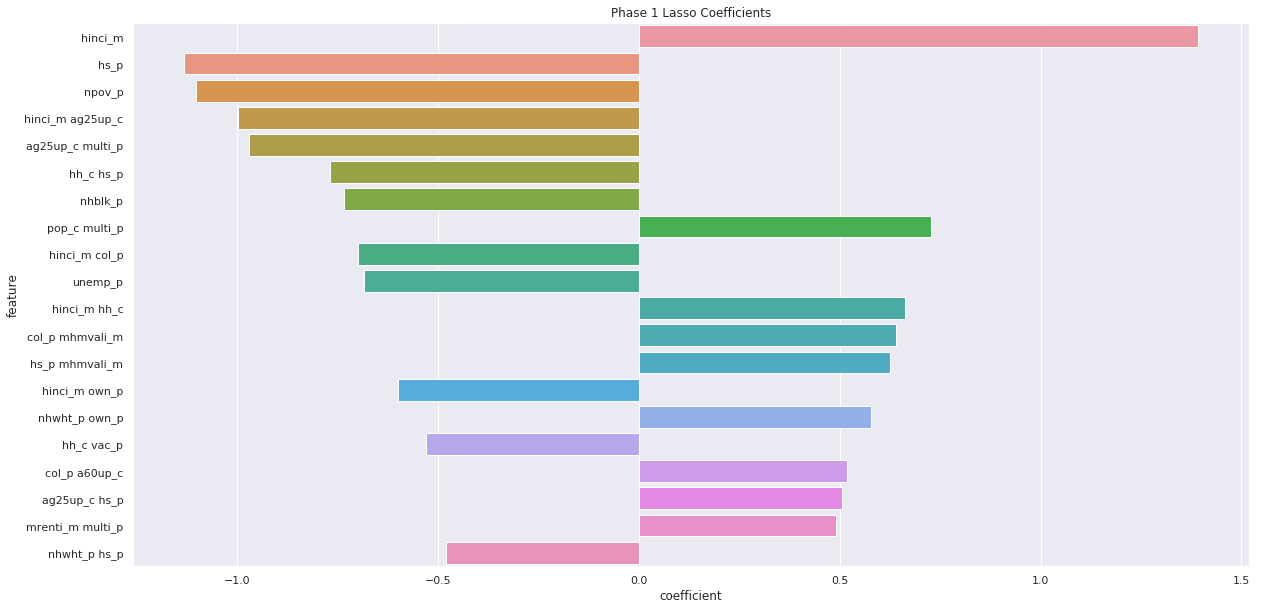

<Figure size 1440x720 with 0 Axes>

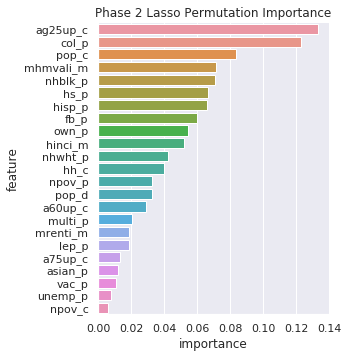

Weight,Feature
0.1333 ± 0.0030,t10_ldb_ag25up_c
0.1227 ± 0.0044,t10_ldb_col_p
0.0838 ± 0.0031,t10_ldb_pop_c
0.0717 ± 0.0038,t10_ldb_mhmvali_m
0.0708 ± 0.0041,t10_ldb_nhblk_p
0.0669 ± 0.0031,t10_ldb_hs_p
0.0662 ± 0.0021,t10_ldb_hisp_p
0.0599 ± 0.0038,t10_ldb_fb_p
0.0544 ± 0.0028,t10_ldb_own_p
0.0520 ± 0.0041,t10_ldb_hinci_m


CPU times: user 28.1 s, sys: 12.5 s, total: 40.6 s
Wall time: 7min 35s


In [51]:
%%time
p2_lasso = linear_model(Lasso(), lasso_grid, cv_5, X_train[p2_features], y_train, '2');

### Ridge

Phase 1 Ridge R^2 Value: 0.6272993085702773
Best Parameters: {'estimator__alpha': 31.622776601683793, 'poly__degree': 2}

Best R^2 Value with No Polynomial Features or Interactions: 0.5988428690841189



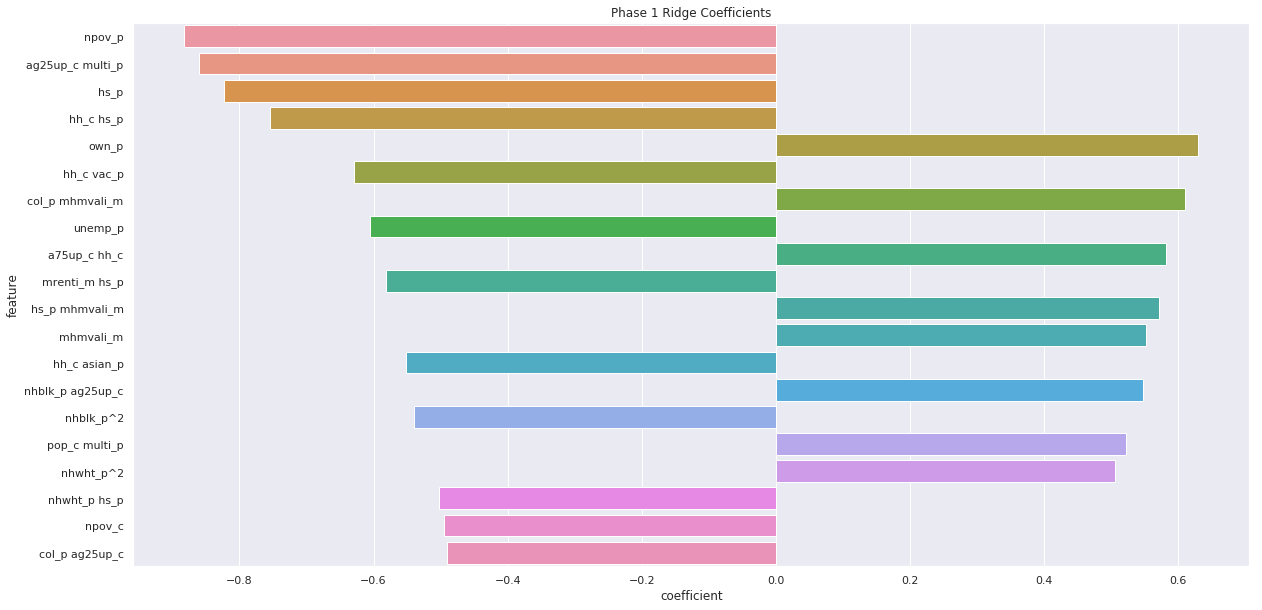

<Figure size 1440x720 with 0 Axes>

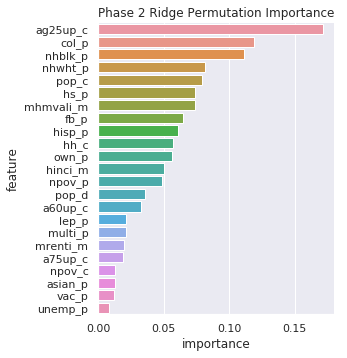

Weight,Feature
0.1717 ± 0.0022,t10_ldb_ag25up_c
0.1189 ± 0.0036,t10_ldb_col_p
0.1116 ± 0.0048,t10_ldb_nhblk_p
0.0814 ± 0.0054,t10_ldb_nhwht_p
0.0792 ± 0.0025,t10_ldb_pop_c
0.0738 ± 0.0033,t10_ldb_hs_p
0.0736 ± 0.0031,t10_ldb_mhmvali_m
0.0649 ± 0.0022,t10_ldb_fb_p
0.0607 ± 0.0044,t10_ldb_hisp_p
0.0574 ± 0.0027,t10_ldb_hh_c


CPU times: user 20.4 s, sys: 11.2 s, total: 31.7 s
Wall time: 3min 27s


In [53]:
%%time
p2_ridge = linear_model(Ridge(), ridge_grid, cv_5, X_train[p2_features], y_train, '2');

### ElasticNet
Using 3rd order polynomials increases complexity and processing time, but wasn't showing better results for LASSO or Ridge.  Therefore, I won't use it for ElasticNet.

Phase 1 ElasticNet R^2 Value: 0.6281387333791015
Best Parameters: {'estimator__alpha': 0.001, 'estimator__l1_ratio': 0.25, 'poly__degree': 2}

Best R^2 Value with No Polynomial Features or Interactions: 0.5988472536817983



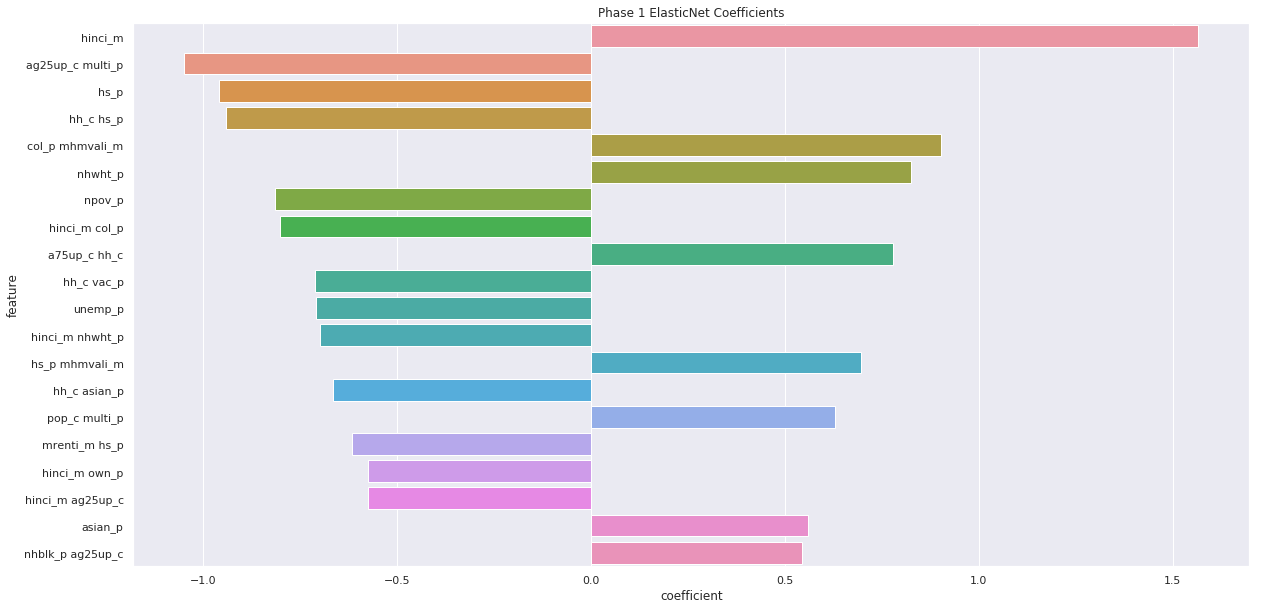

<Figure size 1440x720 with 0 Axes>

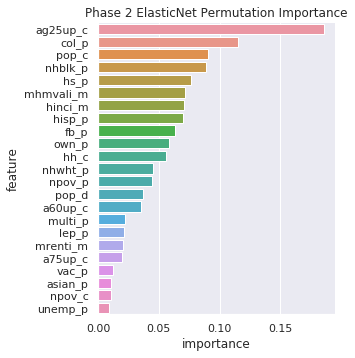

Weight,Feature
0.1859 ± 0.0019,t10_ldb_ag25up_c
0.1148 ± 0.0064,t10_ldb_col_p
0.0902 ± 0.0033,t10_ldb_pop_c
0.0890 ± 0.0044,t10_ldb_nhblk_p
0.0763 ± 0.0044,t10_ldb_hs_p
0.0716 ± 0.0032,t10_ldb_mhmvali_m
0.0710 ± 0.0033,t10_ldb_hinci_m
0.0698 ± 0.0040,t10_ldb_hisp_p
0.0634 ± 0.0022,t10_ldb_fb_p
0.0584 ± 0.0025,t10_ldb_own_p


CPU times: user 29.7 s, sys: 12.6 s, total: 42.4 s
Wall time: 6min 23s


In [54]:
%%time
elastic_grid_p2 = {
    'estimator__alpha': np.logspace(-3, 3, 5),
    'estimator__l1_ratio': np.linspace(0, 1, 5),
    'poly__degree': [1, 2]
             }
p2_elastic = linear_model(ElasticNet(), elastic_grid_p2, cv_5, X_train[p2_features], y_train, '2');

## Nonlinear Models
### Random Forests

I should remember to re-tune for number of estimators to see if I need more now.

In [ ]:
rf_p2 = RandomForestRegressor(n_estimators=150, oob_score=True, random_state=42)
grid = {
    'max_features': ['auto', 'sqrt'],
    'max_depth': [1, 5, 10, 20, None]
}

best_score=0
for g in ParameterGrid(grid):
    rf_p2.set_params(**g)
    rf_p2.fit(X_train[p2_features], y_train)
    # save if best
    if rf_p2.oob_score_ > best_score:
        best_score_p2 = rf_p2.oob_score_
        best_grid_p2 = g

In [57]:
print('Best R^2 Value: {}\n\
Best Parameter Grid: {}'.format(best_score_p2, best_grid_p2))

Best R^2 Value: 0.6325655261499548
Best Parameter Grid: {'max_depth': None, 'max_features': 'sqrt'}


Text(0.5, 1.0, 'Gini Importances: Phase 2 Random Forest')

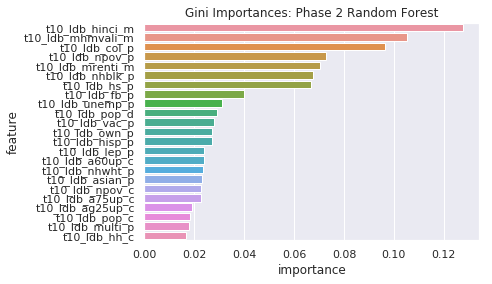

In [62]:
rf_p2_imp = pd.DataFrame({
    'feature': p2_features,
    'importance': rf_p2.feature_importances_ 
}) \
.sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=rf_p2_imp, orient='h')
plt.title('Gini Importances: Phase 2 Random Forest')

<Figure size 1440x720 with 0 Axes>

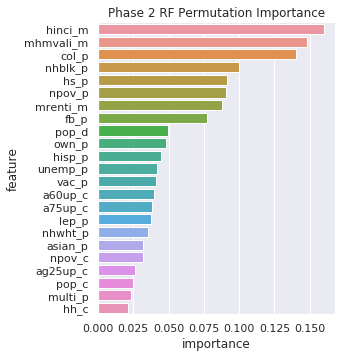

Weight,Feature
0.1601 ± 0.0045,t10_ldb_hinci_m
0.1482 ± 0.0012,t10_ldb_mhmvali_m
0.1403 ± 0.0029,t10_ldb_col_p
0.0996 ± 0.0020,t10_ldb_nhblk_p
0.0914 ± 0.0016,t10_ldb_hs_p
0.0904 ± 0.0008,t10_ldb_npov_p
0.0875 ± 0.0014,t10_ldb_mrenti_m
0.0770 ± 0.0013,t10_ldb_fb_p
0.0496 ± 0.0010,t10_ldb_pop_d
0.0484 ± 0.0015,t10_ldb_own_p


In [65]:
perm_p2 = PermutationImportance(rf_p2, scoring='r2') \
        .fit(X_train[p2_features], y_train, cv='prefit')
    
plt.figure(figsize=(20,10));
plot_perm = perm_plot(perm_p2, p2_features)
plt.title('Phase 2 RF Permutation Importance')    
plt.show()

display(show_weights(perm_p2, feature_names=p2_features))    

### Gradient Boosting with XGBoost

# Phase 3
Features will include only NETS retail variables and green space (no census or ACS variables)

- ACT_C - all clinical treatment
- AMB_C - ambulatory care
- APA_C - all physical activity facilities
- AUR_C - all unhealthy food sources
- BAR_C - bars
- CER_C - cognitive enrichment destinations
- DRA_C - all pharmacies and drug stores
- FFA_C - all fast food
- FIN_C - all financial institutions
- FSA_C - all food stores
- FSR_C - frequent social destinations, restricted version
- HOI_C - hospital based impatient caare
- HSR_C - health food sales, restricted version
- KCT_C - kidney centers
- LIQ_C - liquor stores
- MUL_C - multi-use physical activity facilities
- NGT_C - nighttime social interaction destinations
- PHT_C - physical therapy locations
- RES_C - residential facilities with healthcare
- SRV_C - individual and family social services
- WAL_C - walkable destinations for daily living

In [ ]:
p3_features = [x for x in X_train.columns if 'net' in x or 'use' in x]

## Linear Models
### LASSO

Phase 1 Lasso R^2 Value: 0.245349205548864
Best Parameters: {'estimator__alpha': 0.03162277660168379, 'poly__degree': 3}

Best R^2 Value with No Polynomial Features or Interactions: 0.22149160530705345



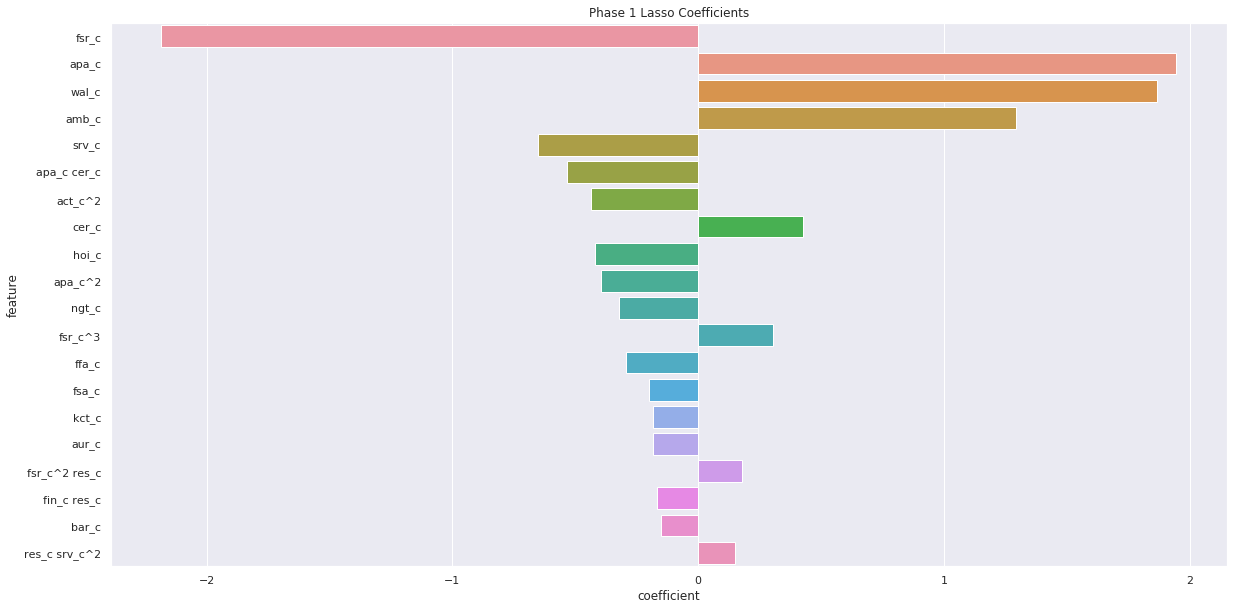

<Figure size 1440x720 with 0 Axes>

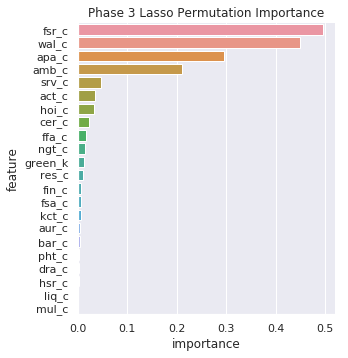

Weight,Feature
0.4958 ± 0.0104,t10_net_fsr_c
0.4498 ± 0.0094,t10_net_wal_c
0.2955 ± 0.0070,t10_net_apa_c
0.2100 ± 0.0059,t10_net_amb_c
0.0460 ± 0.0049,t10_net_srv_c
0.0343 ± 0.0011,t10_net_act_c
0.0316 ± 0.0023,t10_net_hoi_c
0.0216 ± 0.0019,t10_net_cer_c
0.0169 ± 0.0030,t10_net_ffa_c
0.0139 ± 0.0022,t10_net_ngt_c


CPU times: user 3min 7s, sys: 17.9 s, total: 3min 25s
Wall time: 9min 44s


In [67]:
%%time
p3_lasso = linear_model(Lasso(), lasso_grid, cv_5, X_train[p3_features], y_train, '3');

## Nonlinear Models
### Random Forests

In [ ]:
%%capture

train_scores = []
oob_scores = []
test_scores = []

rf_p3 = RandomForestRegressor(warm_start=True, oob_score=True, random_state=42);
estimator_range = range(1, 500, 20)
for n_estimators in estimator_range:
    rf_p3.n_estimators = n_estimators;
    rf_p3.fit(X_train[p3_features], y_train);
    train_scores.append(rf_p3.score(X_train[p3_features], y_train));
    oob_scores.append(rf_p3.oob_score_);
    print('.')

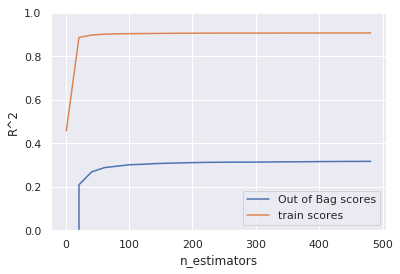

In [69]:
plt.plot(estimator_range, oob_scores, label="Out of Bag scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("R^2")
plt.xlabel("n_estimators")
plt.ylim(0, 1)
plt.legend()
plt.show()
# plt.savefig("images/warm_start_forest.png")

In [70]:
pd.DataFrame({'num_trees': estimator_range,
              'oob_scores': oob_scores})

,num_trees,oob_scores
0,1,-248.604518
1,21,0.209393
2,41,0.268686
3,61,0.288188
4,81,0.294993
5,101,0.301582
6,121,0.303487
7,141,0.306715
8,161,0.308514
9,181,0.309841


We'll use 200 trees

In [ ]:
rf_p3 = RandomForestRegressor(n_estimators=150, oob_score=True, random_state=42)
grid = {
    'max_features': ['auto', 'sqrt'],
    'max_depth': [1, 5, 10, 20, None]
}

best_score=0
for g in ParameterGrid(grid):
    rf_p3.set_params(**g)
    rf_p3.fit(X_train[p3_features], y_train)
    # save if best
    if rf_p3.oob_score_ > best_score:
        best_score_p3 = rf_p3.oob_score_
        best_grid_p3 = g

In [ ]:
print('Best R^2 Value: {}\n\
Best Parameter Grid: {}'.format(best_score_p3, best_grid_p3))

Best R^2 Value: 0.6325655261499548
Best Parameter Grid: {'max_depth': None, 'max_features': 'sqrt'}


Text(0.5, 1.0, 'Gini Importances: Phase 2 Random Forest')

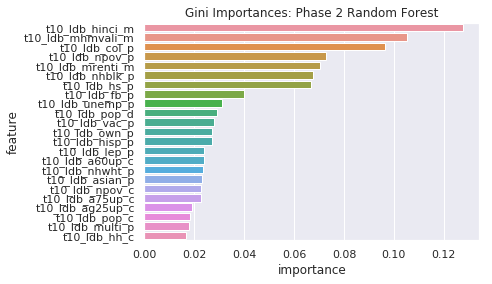

In [ ]:
rf_p3_imp = pd.DataFrame({
    'feature': p3_features,
    'importance': rf_p3.feature_importances_ 
}) \
.sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=rf_p3_imp, orient='h')
plt.title('Gini Importances: Phase 2 Random Forest')

<Figure size 1440x720 with 0 Axes>

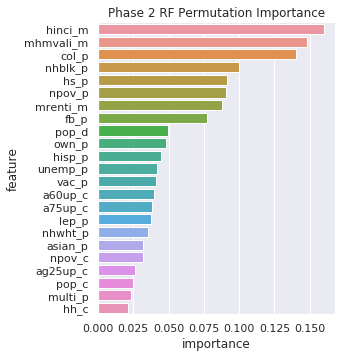

Weight,Feature
0.1601 ± 0.0045,t10_ldb_hinci_m
0.1482 ± 0.0012,t10_ldb_mhmvali_m
0.1403 ± 0.0029,t10_ldb_col_p
0.0996 ± 0.0020,t10_ldb_nhblk_p
0.0914 ± 0.0016,t10_ldb_hs_p
0.0904 ± 0.0008,t10_ldb_npov_p
0.0875 ± 0.0014,t10_ldb_mrenti_m
0.0770 ± 0.0013,t10_ldb_fb_p
0.0496 ± 0.0010,t10_ldb_pop_d
0.0484 ± 0.0015,t10_ldb_own_p


In [ ]:
perm_p2 = PermutationImportance(rf_p3, scoring='r2') \
        .fit(X_train[p3_features], y_train, cv='prefit')
    
plt.figure(figsize=(20,10));
plot_perm = perm_plot(perm_p3, p3_features)
plt.title('Phase 3 RF Permutation Importance')    
plt.show()

display(show_weights(perm_p3, feature_names=p3_features))    

### Gradient Boosting with XGBoost